In [148]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedShuffleSplit, GroupKFold, permutation_test_score, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, classification_report, roc_auc_score, mean_squared_error
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from nltools.stats import fisher_r_to_z, fisher_z_to_r
from IPython.display import display
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import warnings
import statsmodels.api as sm

MAX_INT = np.iinfo(np.int32).max
palette = sns.color_palette("Paired")

fpath = './Data/archive'

<ipython-input-148-f2353099c158>:18: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


* Data resource: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing/data

* Goal: 找出電話行銷高機率購買定存客戶樣貌之假設

In [149]:
df = pd.read_csv(os.path.join(fpath, 'bank-additional-full.csv'), delimiter=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


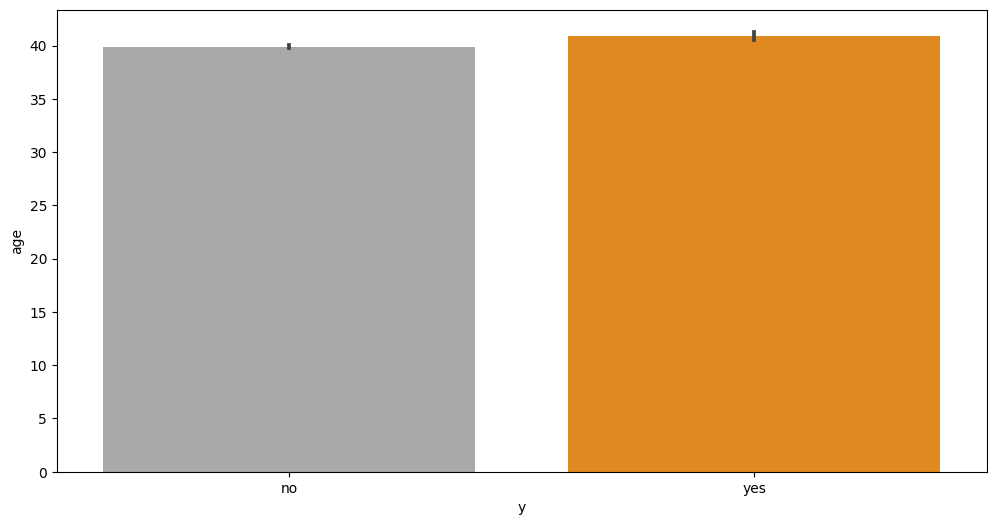

T-statistic: 6.172087109640128, p-value: 6.80213641846347e-10


In [150]:
# Age
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='y', y='age', ci=95, palette=['darkgray', 'darkorange'])
plt.show()
# T-test
YES = df[df['y']=='yes']['age']
NO = df[df['y']=='no']['age']
t_statistic, p_value = ttest_ind(YES, NO)
print(f"T-statistic: {t_statistic}, p-value: {p_value}")

# Encode the data

In [151]:
# Grouping the age data into 5 age groups
bins = [0, 30, 40, 50, float('inf')]
df['age_group'] = pd.cut(df['age'], bins=bins, labels=['<30', '30-40', '40-50', '50>'])
df.drop('age', axis=1, inplace=True) # dropping the original age column
df.head(5)

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>
1,services,married,high.school,unknown,no,no,telephone,may,mon,149,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>
2,services,married,high.school,no,yes,no,telephone,may,mon,226,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30-40
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30-40
4,services,married,high.school,no,no,yes,telephone,may,mon,307,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>


In [152]:
# Reset 'education' labels
df['education'] = df['education'].replace(['basic.4y', 'basic.6y', 'basic.9y'], 'basic.education')
df['education'].value_counts() # Check the number of each label

basic.education        12513
university.degree      12168
high.school             9515
professional.course     5243
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [153]:
# length of all columns is 21 (including 'y' column)
df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'age_group'],
      dtype='object')

In [154]:
# Divide different kinds of columns into numerical and categorical
# length of num_cols is 9, and length of cat_cols is 11
num_cols = ['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_group']

In [155]:
df.describe()

,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [156]:
# Check if NA values exist in the dataset
df.isna().sum() # No NA values exist

job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
age_group         0
dtype: int64

# Descriptive statistics

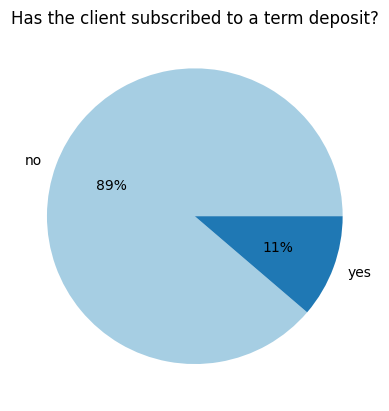

In [157]:
# Generate a pie chart to visualize the distribution of whether clients have subscribed to a term deposit.
target_var = pd.crosstab(index=df['y'], columns='% observations')
plt.pie(target_var['% observations'], labels=target_var['% observations'].index, autopct='%.0f%%', colors=palette)
plt.title('Has the client subscribed to a term deposit?')
plt.show()

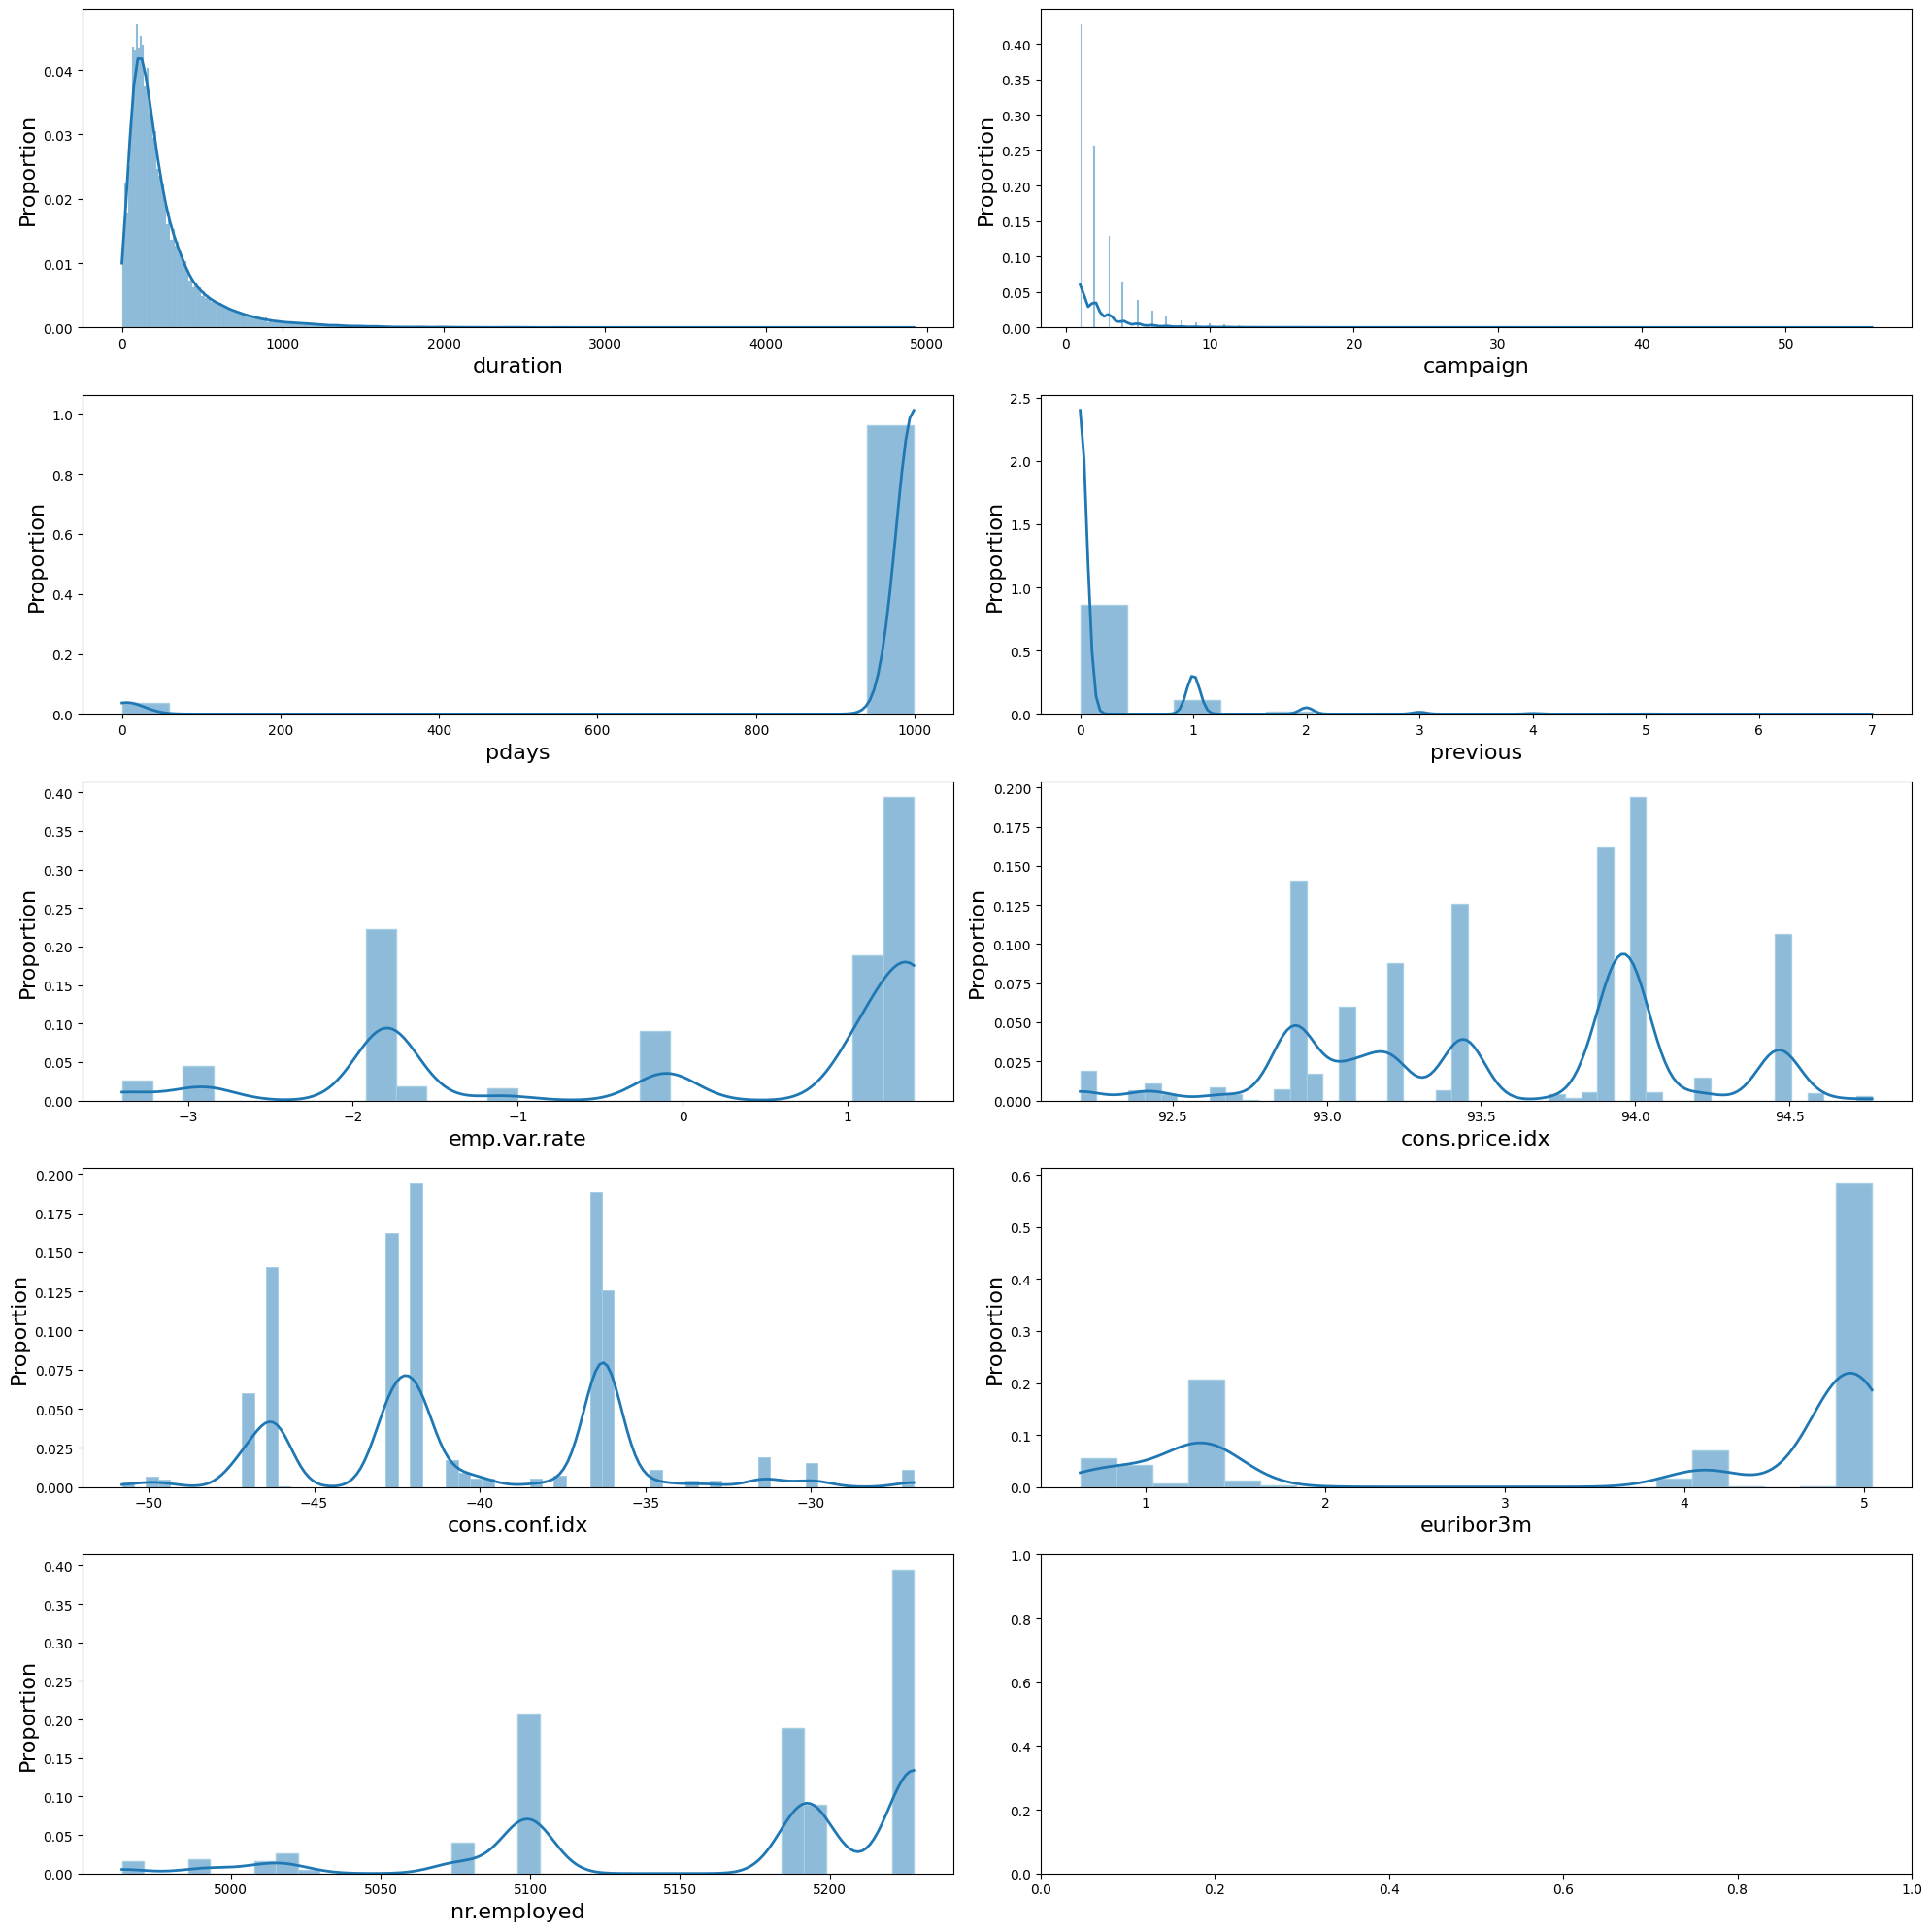

In [158]:
# Visualize the numerical columns with seaborn
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, ax=axes[i//2, i%2], stat="proportion", kde=True, color=palette[1], edgecolor=palette[0]
                 , line_kws={'color': palette[2], 'lw': 2})
    # increase the font-size of subplot x-axis and y-axis labels
    axes[i//2, i%2].set_xlabel(col, fontsize=16)
    axes[i//2, i%2].set_ylabel('Proportion', fontsize=16)
fig.tight_layout()
plt.show()

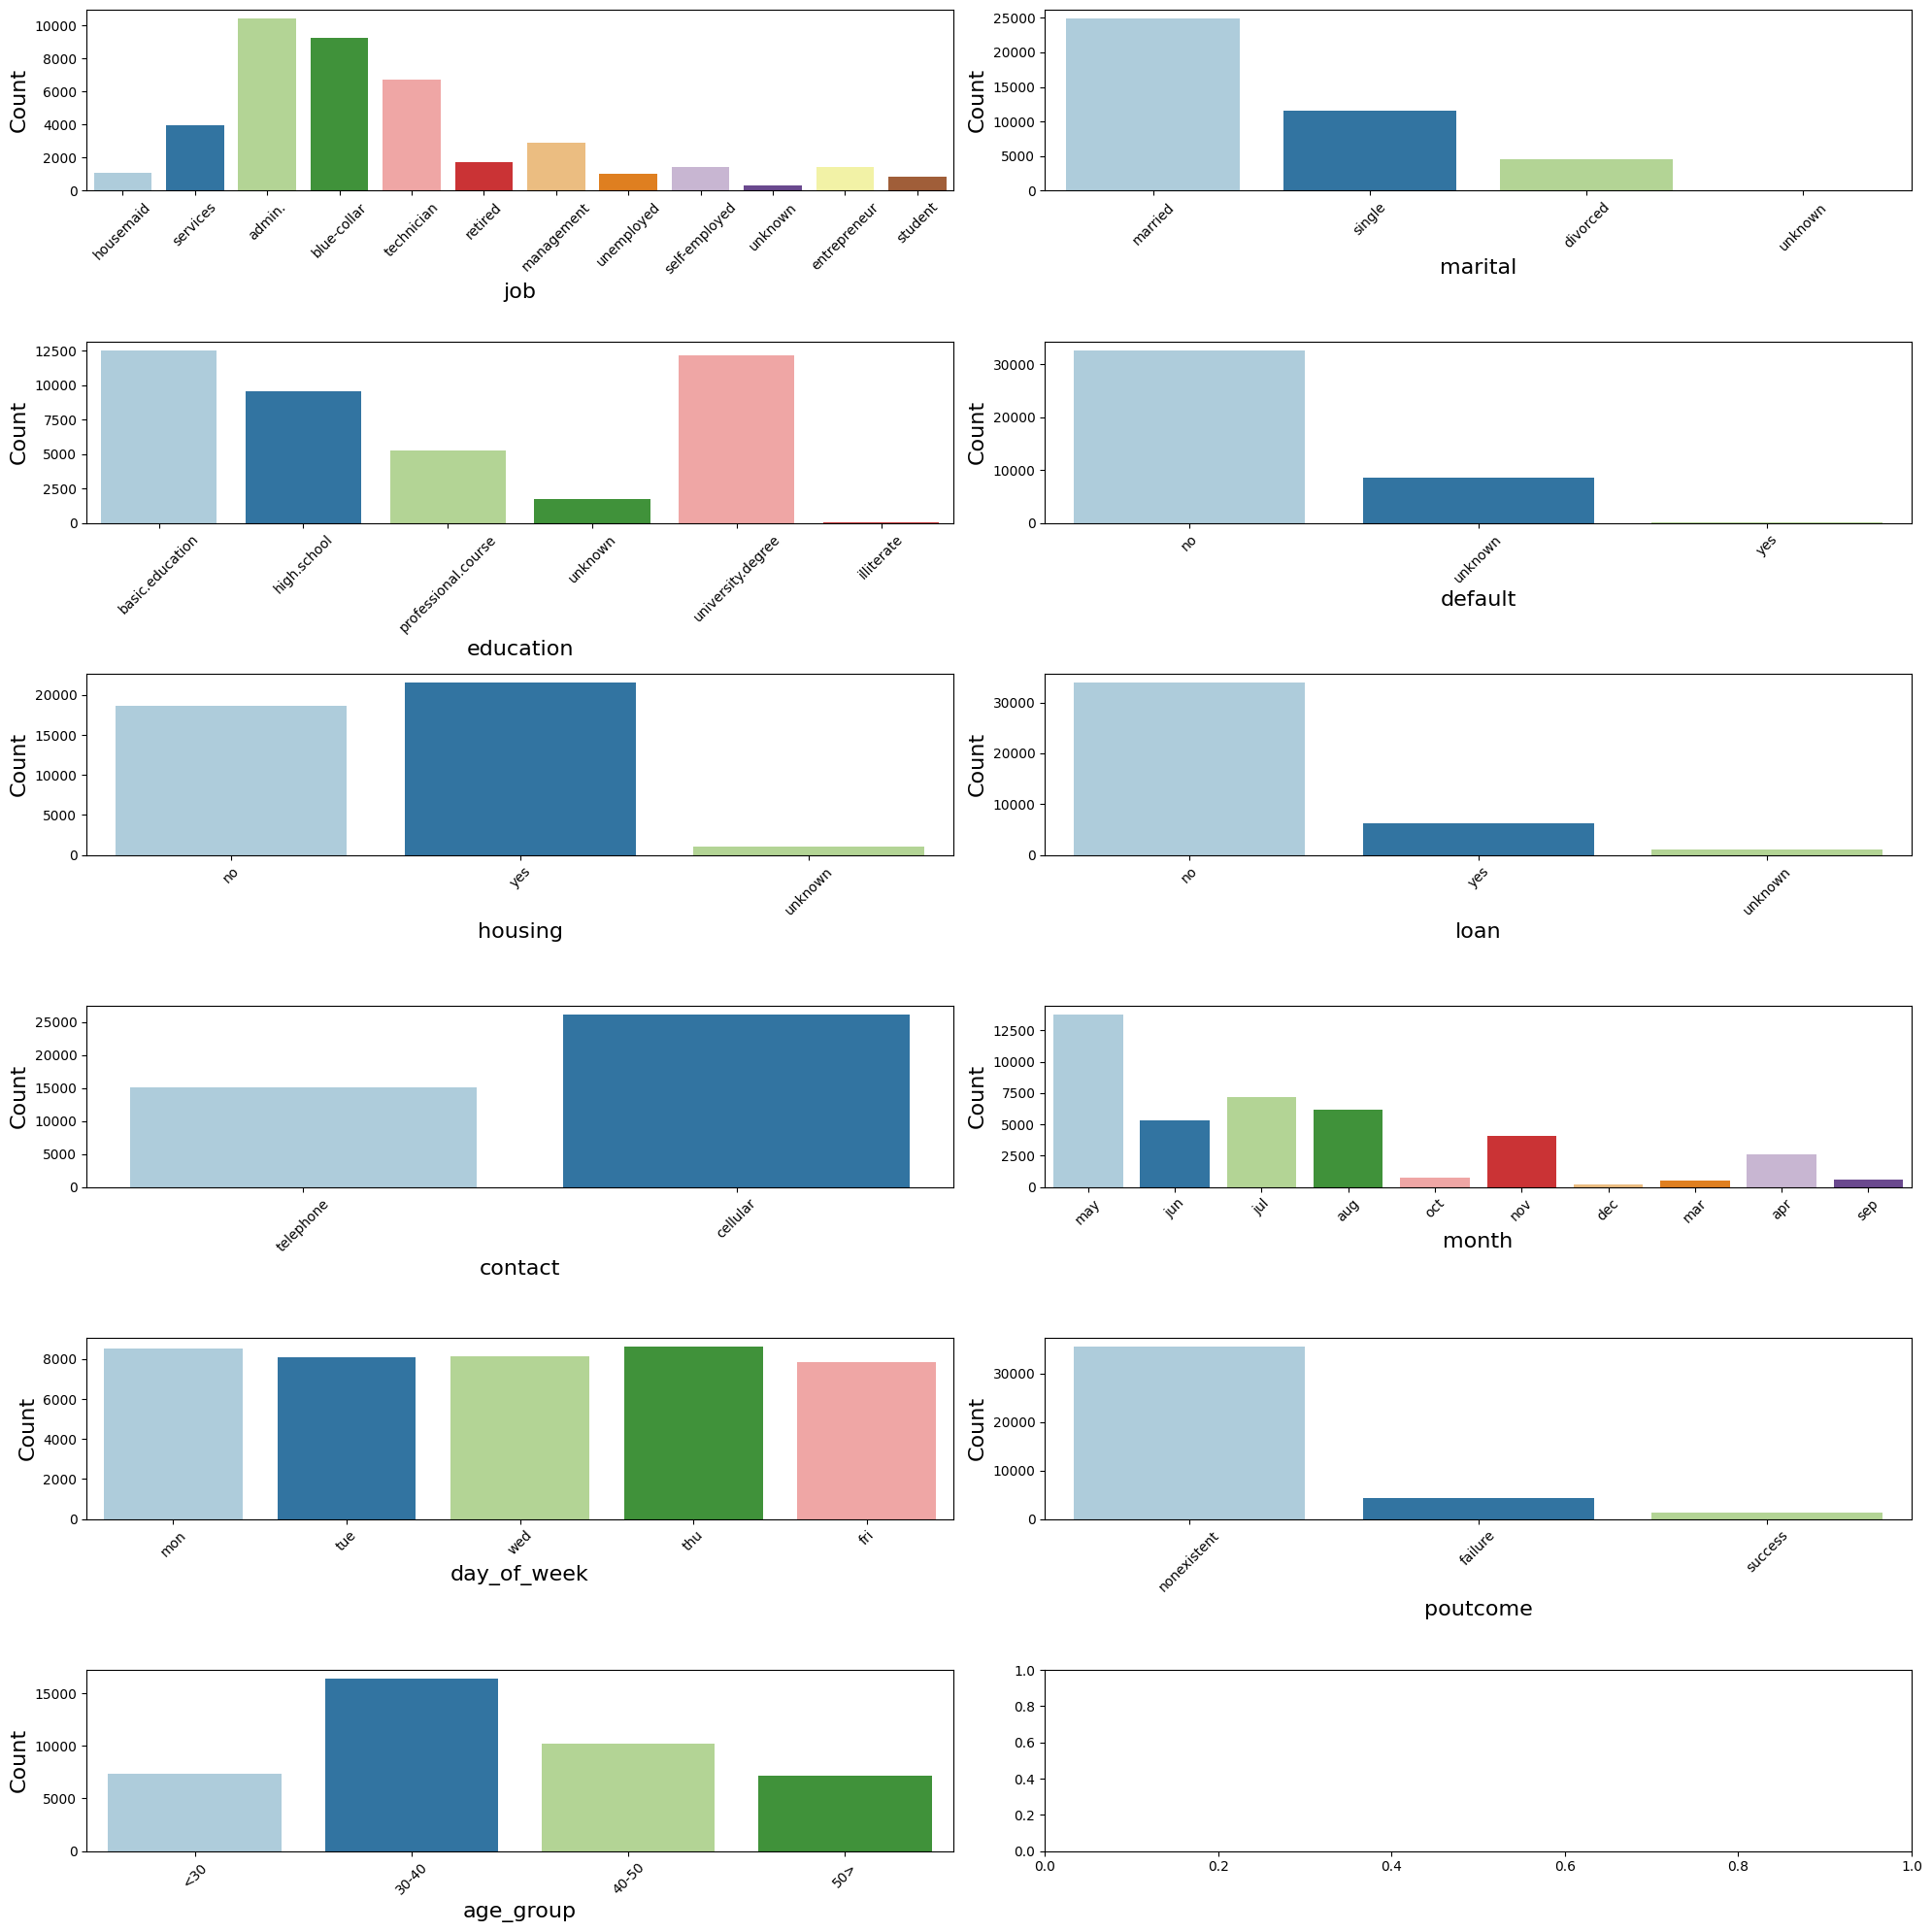

In [159]:
# Visualize the categorical columns with seaborn
fig, axes = plt.subplots(6, 2, figsize=(20, 20))
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i//2, i%2], palette=palette)
    # increase the font-size of subplot x-axis and y-axis labels
    axes[i//2, i%2].set_xlabel(col, fontsize=16)
    axes[i//2, i%2].set_ylabel('Count', fontsize=16)
    # rotate the x-axi labels
    axes[i//2, i%2].tick_params(axis='x', labelrotation=45)
fig.tight_layout()
plt.show()

In [160]:
# From the visualizations above, noticed some irrevalent columns and dicided to removed them.
df = df.drop(['duration', 'pdays', 'previous', 'default'], axis=1)
cat_cols.remove('default')
num_cols = [col for col in num_cols if col not in ['duration', 'pdays', 'previous']] # remove 'duration', 'pdays', 'previous' from num_cols
df

,job,marital,education,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,housemaid,married,basic.education,no,no,telephone,may,mon,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>
1,services,married,high.school,no,no,telephone,may,mon,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>
2,services,married,high.school,yes,no,telephone,may,mon,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30-40
3,admin.,married,basic.education,no,no,telephone,may,mon,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30-40
4,services,married,high.school,no,yes,telephone,may,mon,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,yes,no,cellular,nov,fri,1,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,50>
41184,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,40-50
41185,retired,married,university.degree,yes,no,cellular,nov,fri,2,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,50>
41186,technician,married,professional.course,no,no,cellular,nov,fri,1,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,40-50


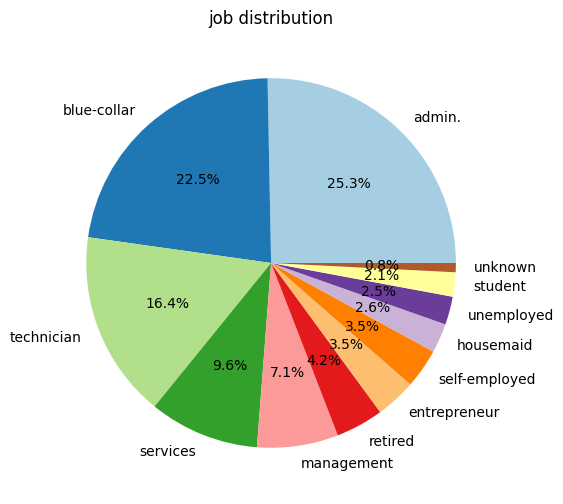

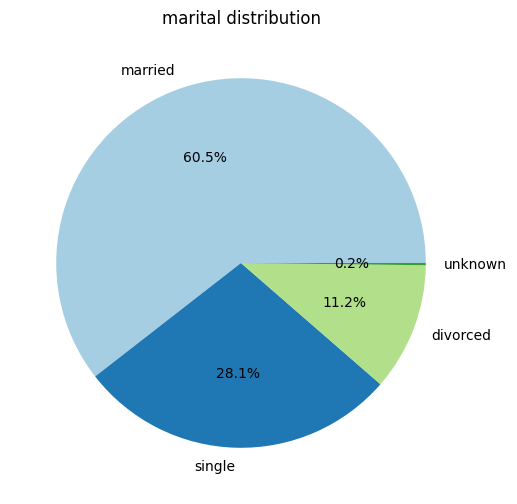

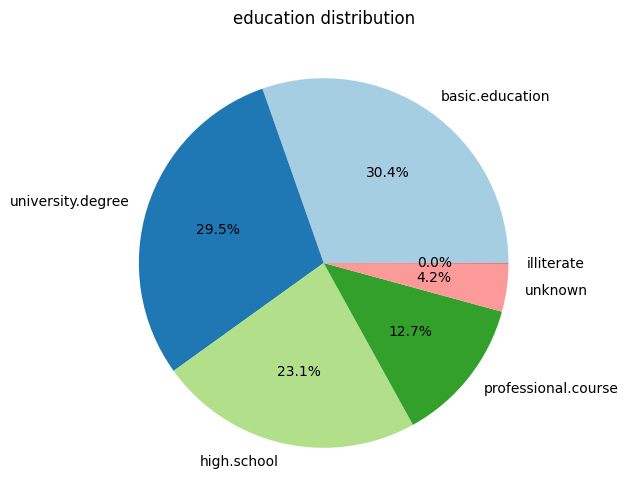

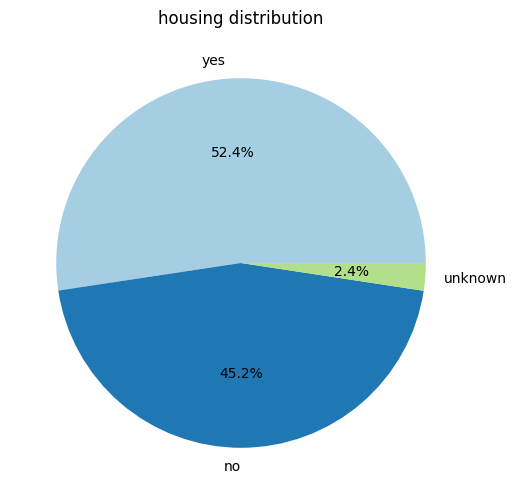

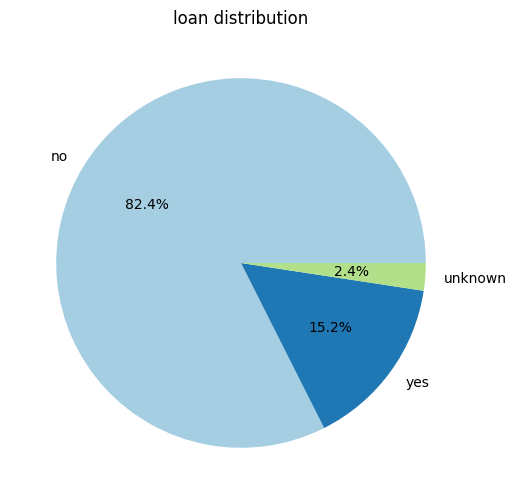

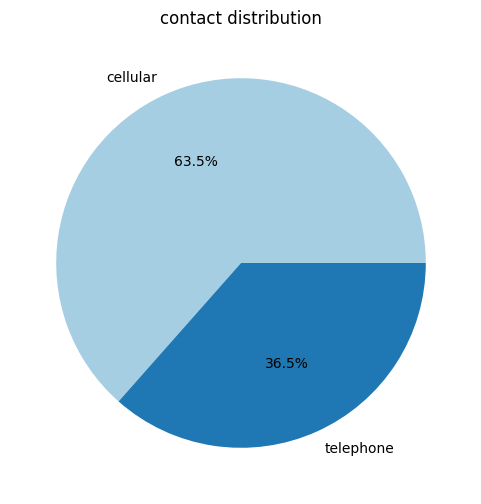

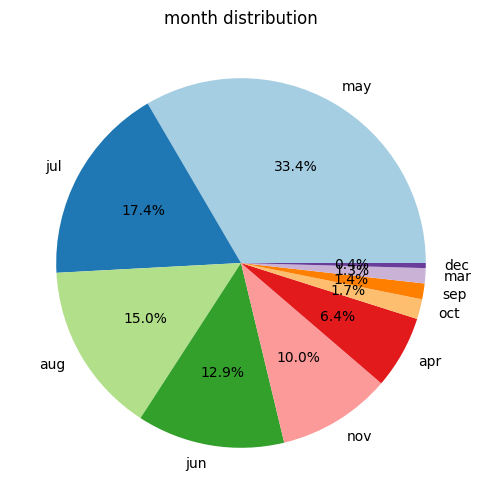

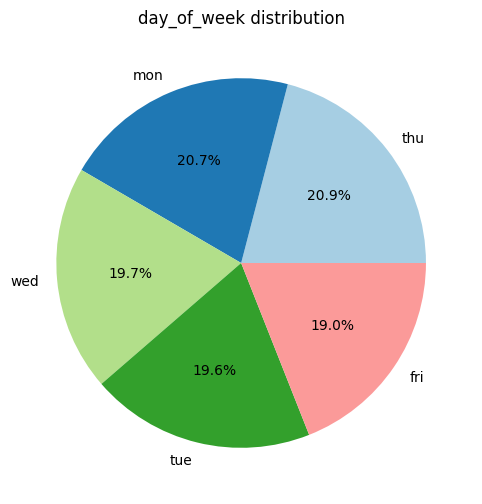

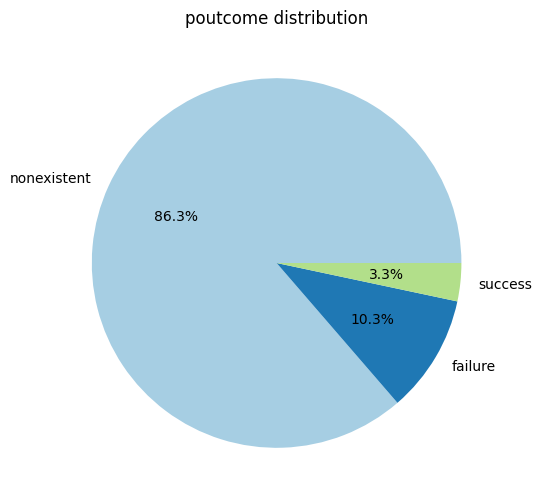

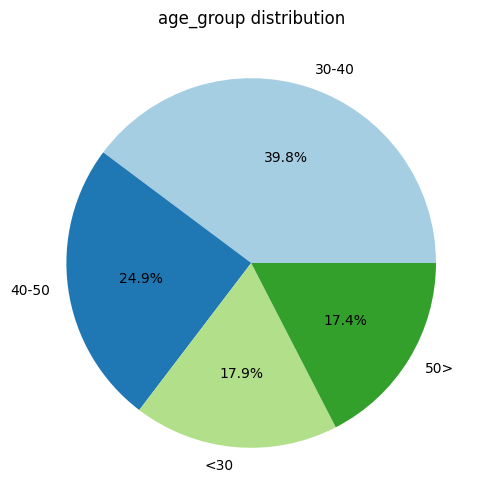

In [161]:
for column in cat_cols:
    plt.figure(figsize=(6, 6))
    df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=palette)
    plt.title(f"{column} distribution")
    plt.ylabel(None) 
    plt.show()

## Numerical data

In [162]:
num_cols

['campaign',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

t-statistic for campaign: -13.4965, p-value: 0.0000
t-statistic for emp.var.rate: -63.4337, p-value: 0.0000
t-statistic for cons.price.idx: -27.9032, p-value: 0.0000
t-statistic for cons.conf.idx: 11.1539, p-value: 0.0000
t-statistic for euribor3m: -65.6466, p-value: 0.0000
t-statistic for nr.employed: -76.9845, p-value: 0.0000


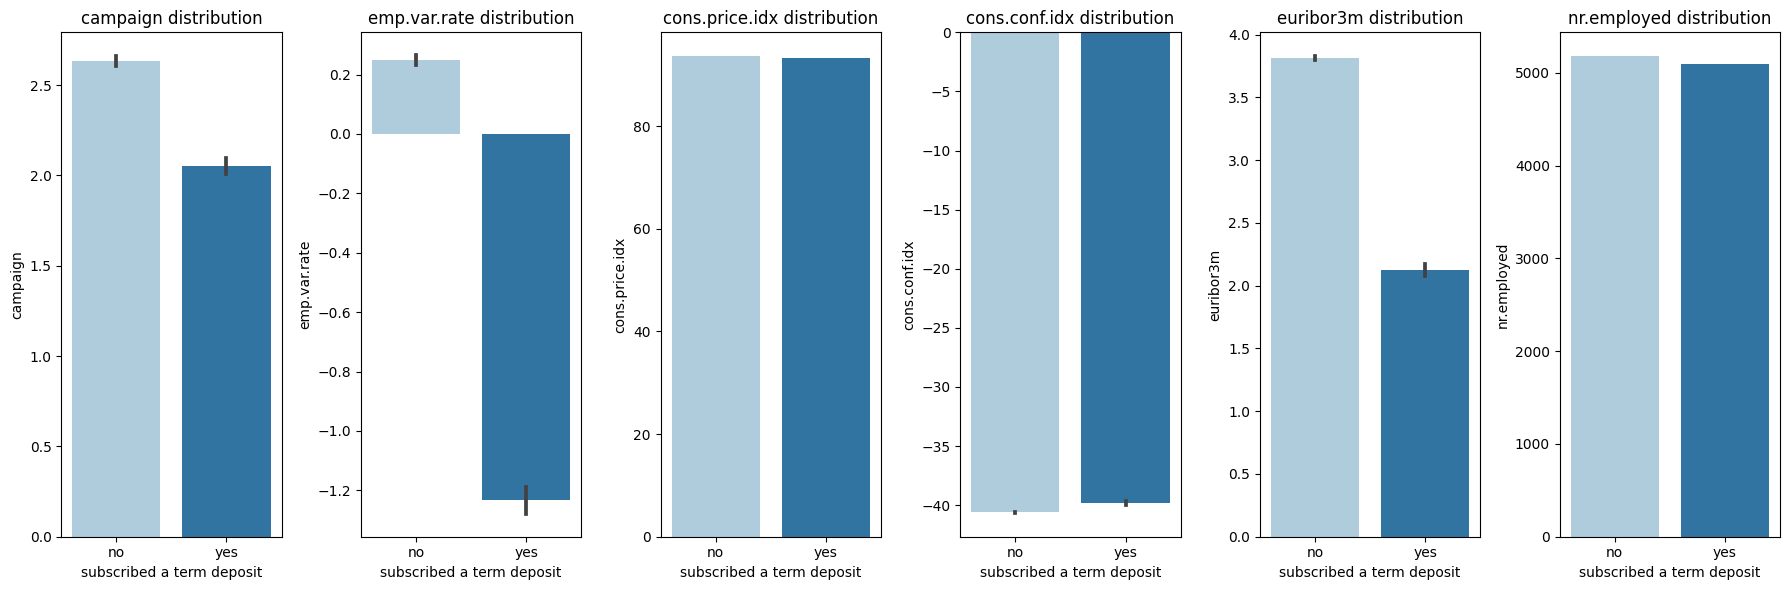

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(18, 6))

# Draw the barplot for each variable in num_cols
for i, col in enumerate(num_cols):
    sns.barplot(x='y', y=col, data=df, palette=palette, ci=95, ax=axes[i])
    axes[i].set_title(f"{col} distribution")
    axes[i].set_xlabel('subscribed a term deposit')
    
    # Conduct t-test
    t_stat, p_val = ttest_ind(df[df['y'] == 'yes'][col], df[df['y'] == 'no'][col])
    print(f"t-statistic for {col}: {t_stat:.4f}, p-value: {p_val:.4f}")
    # Conclusion: p-value < 0.05, we reject the null hypothesis that the two groups have the same mean.

plt.tight_layout()
plt.show()


t-statistic: -13.4965, p-value: 0.0000


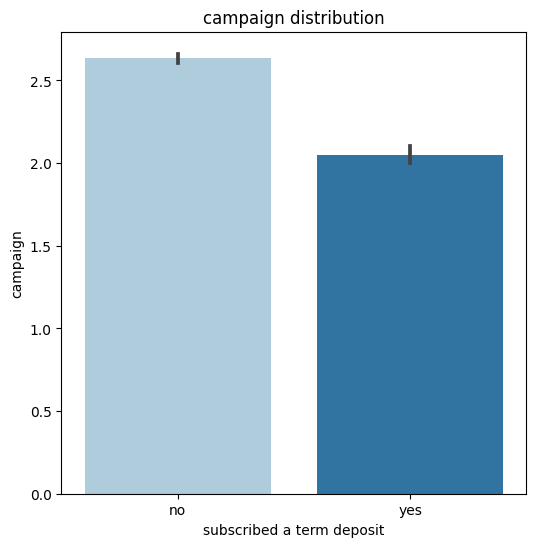

t-statistic: -63.4337, p-value: 0.0000


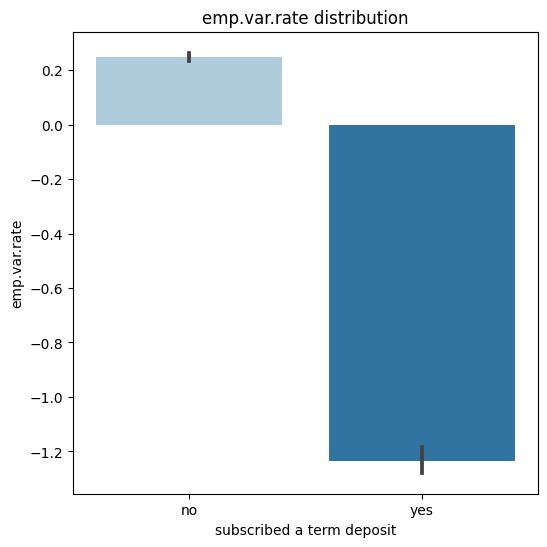

t-statistic: -27.9032, p-value: 0.0000


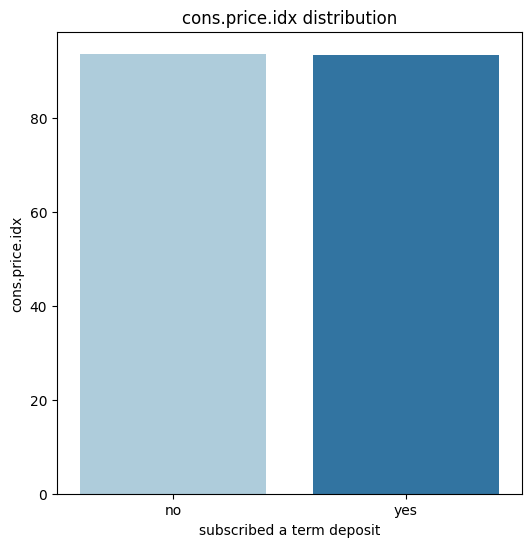

t-statistic: 11.1539, p-value: 0.0000


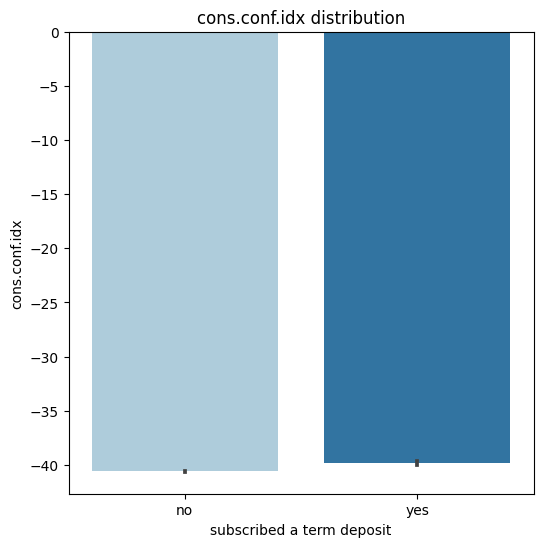

t-statistic: -65.6466, p-value: 0.0000


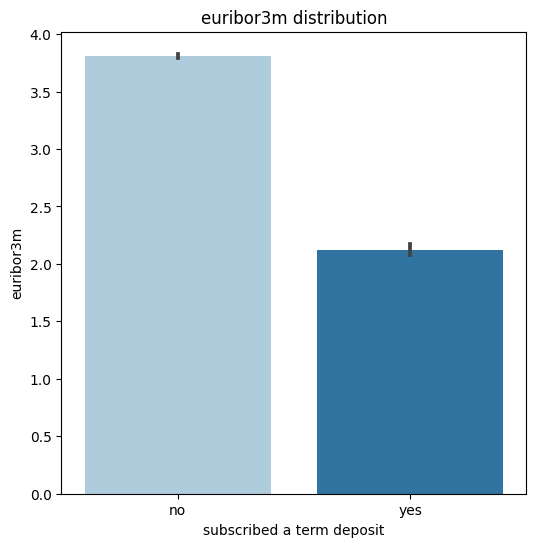

t-statistic: -76.9845, p-value: 0.0000


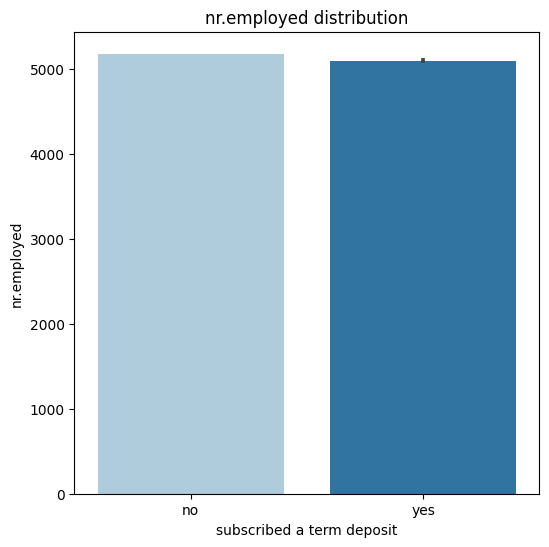

In [164]:
# Draw the barplot for each variables in num_cols
for col in num_cols:
    plt.figure(figsize=(6, 6))
    sns.barplot(x=df['y'], y=df[col], palette=palette, ci=95)
    plt.title(f"{col} distribution")
    plt.xlabel('subscribed a term deposit')
    # Conduct t-test
    t_stat, p_val = ttest_ind(df[df['y'] == 'yes'][col], df[df['y'] == 'no'][col])
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
    # Conclusion: p-value < 0.05, we reject the null hypothesis that the two groups have the same mean.
    plt.show()

## Catgorical  data

In [165]:
cat_cols

['job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'age_group']

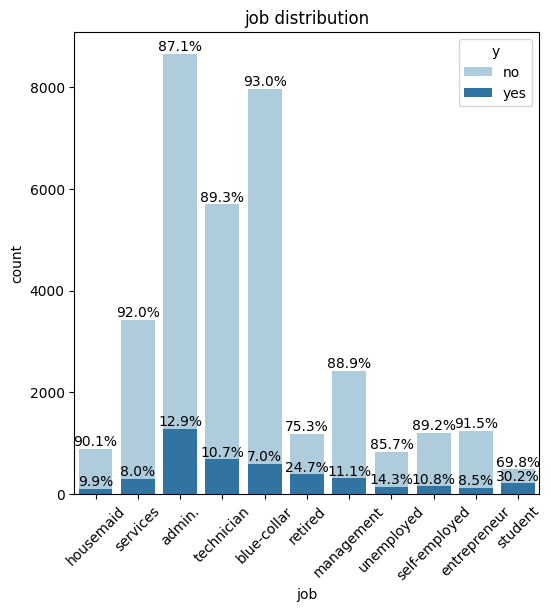

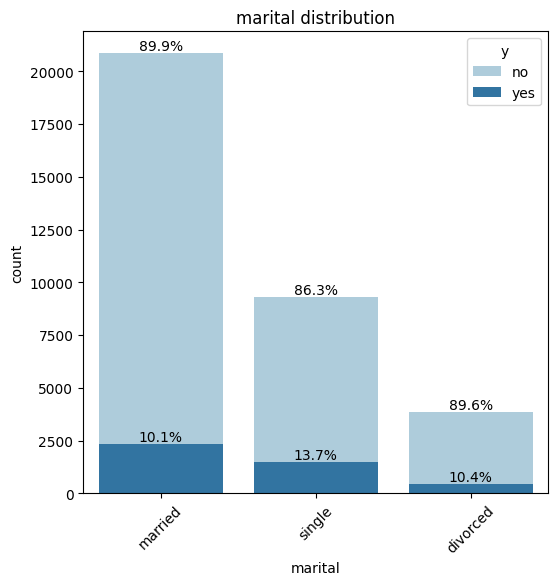

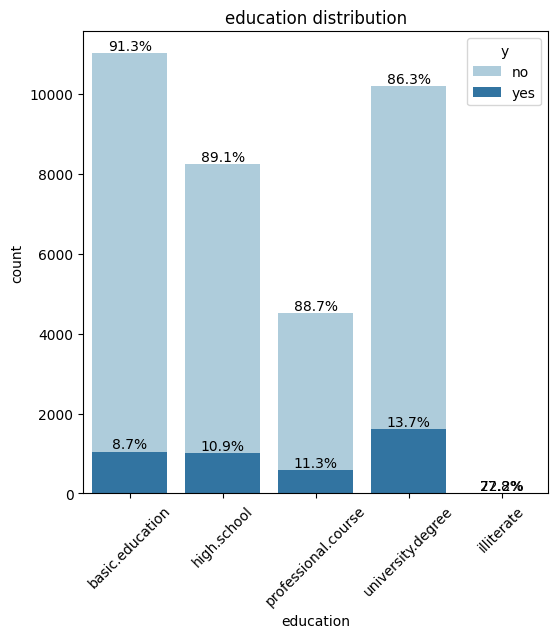

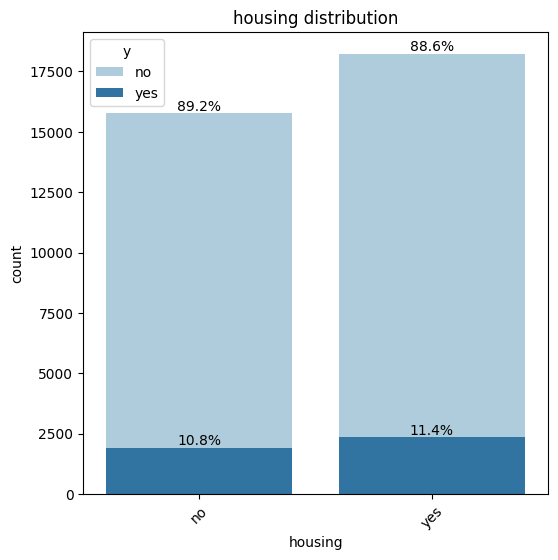

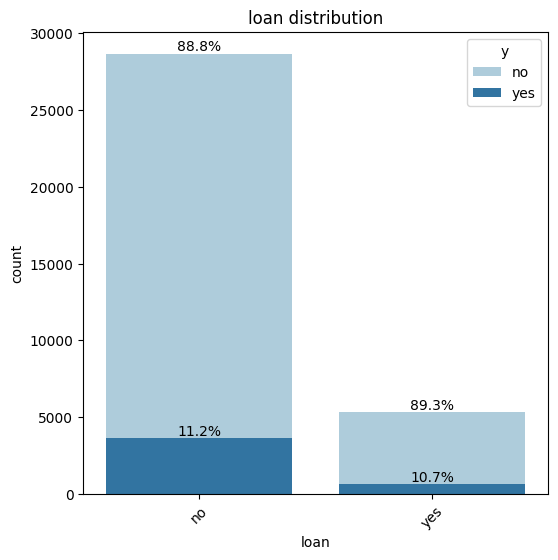

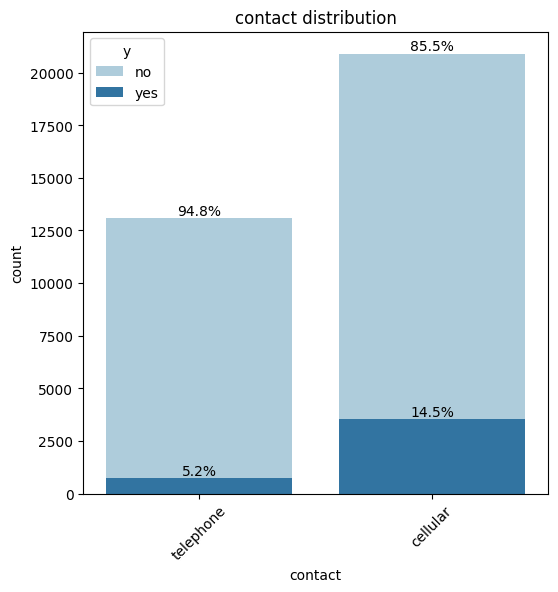

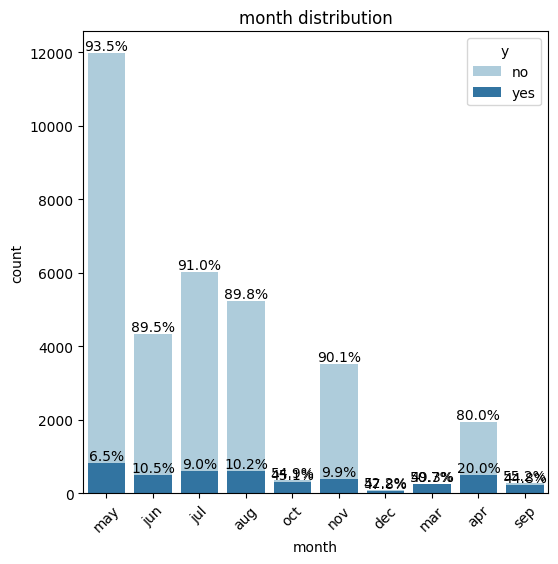

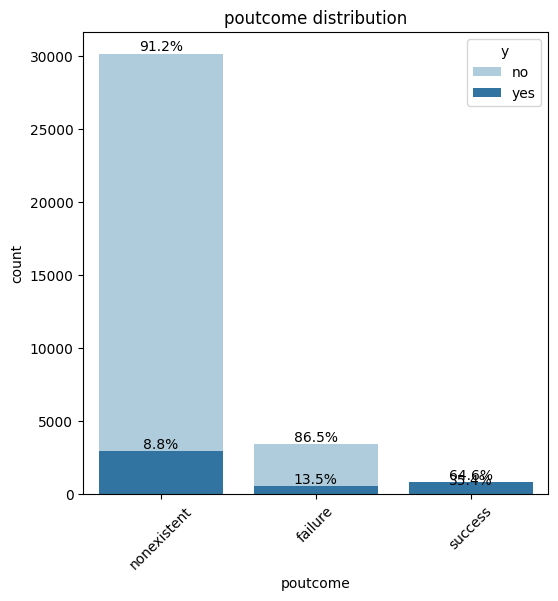

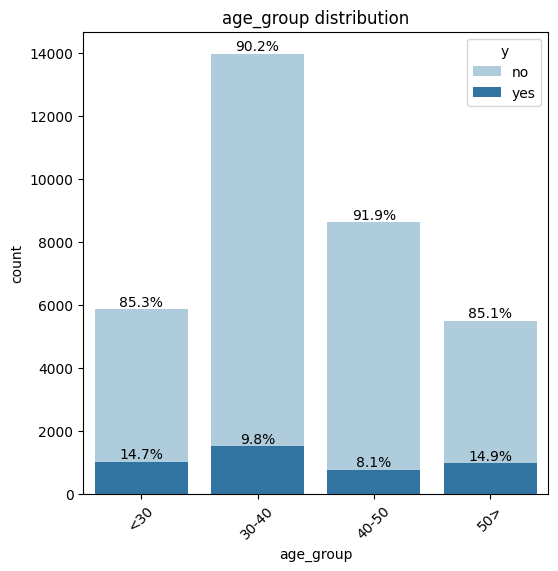

In [250]:

def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=10, ha='center', va='bottom')

# Draw the plot for each variables in cat_cols and show proportion for hues in each bar
for col in cat_cols:
    plt.figure(figsize=(6, 6))
    ax = sns.countplot(x=df[col], hue=df['y'], palette=palette, dodge=False)
    percentage_above_bar_relative_to_xgroup(ax)
    plt.title(f"{col} distribution")
    plt.xlabel(f"{col}")
    plt.xticks(rotation=45)
    plt.show()

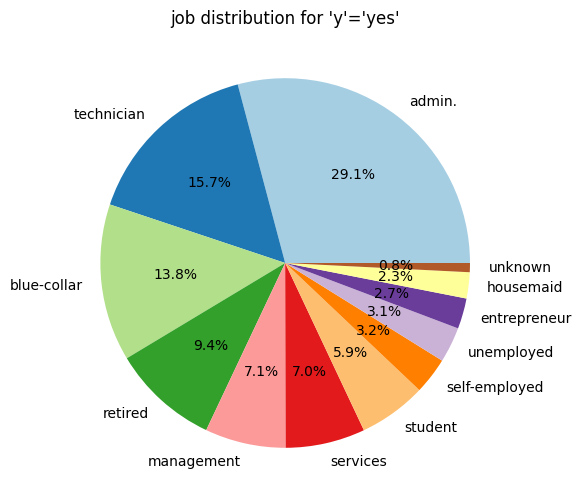

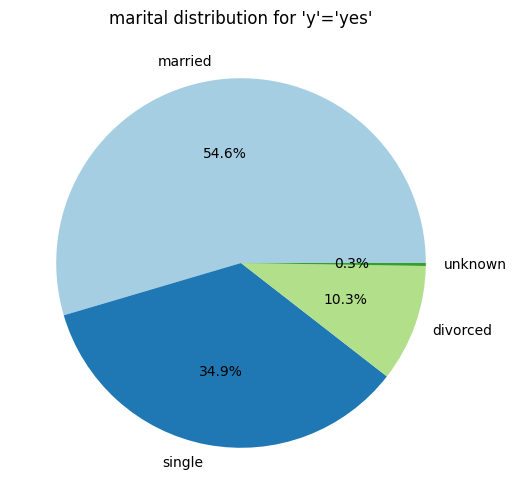

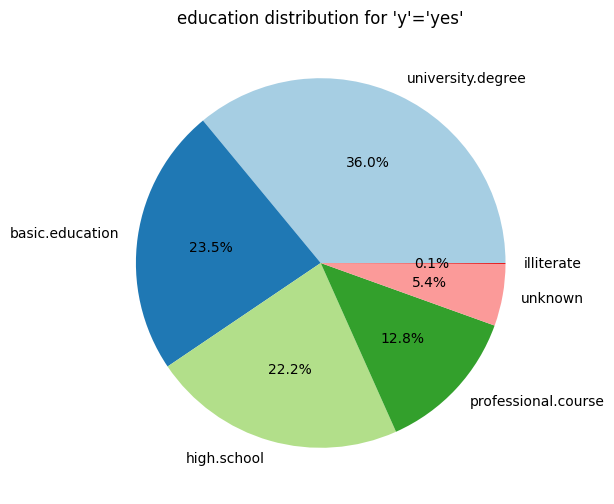

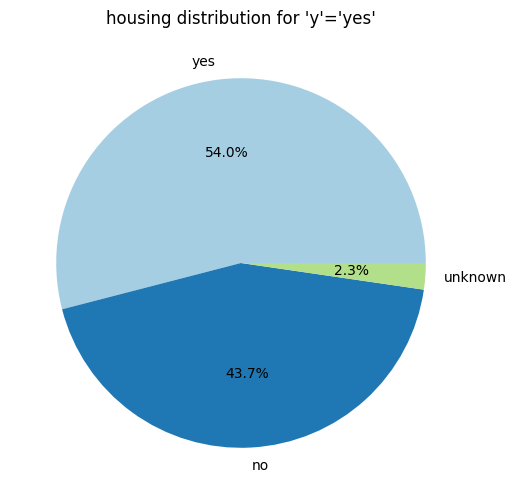

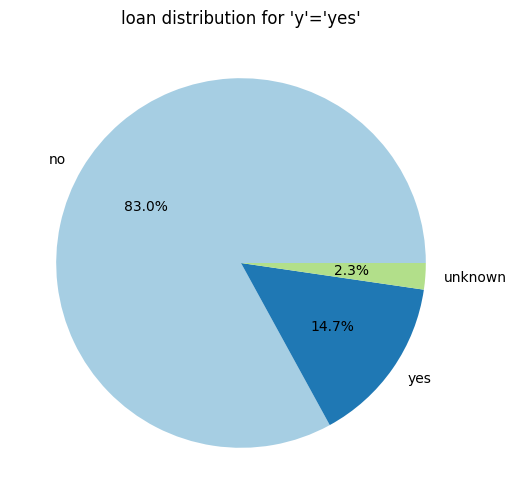

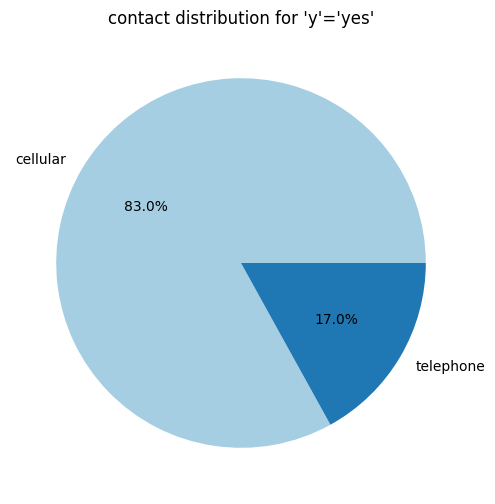

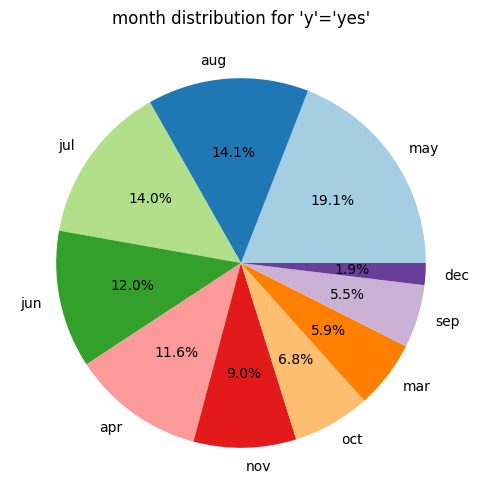

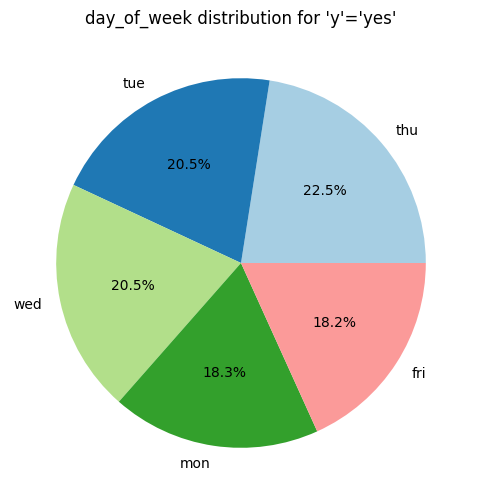

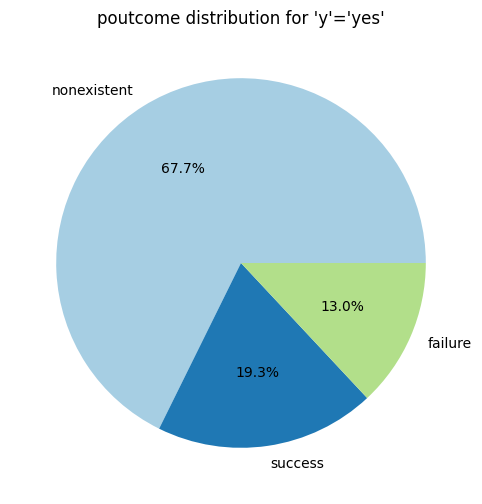

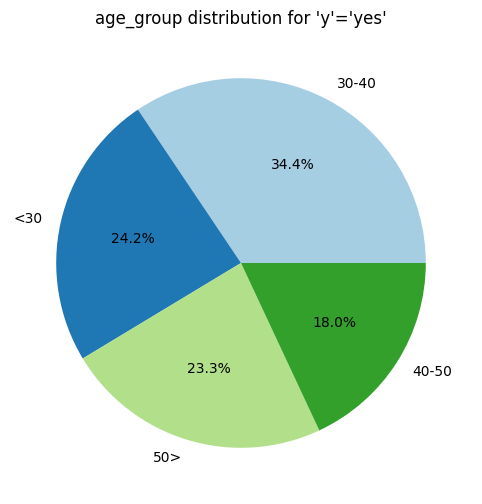

In [167]:
# Draw a pie plot for each variable in cat_cols
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    
    # Filter the dataframe to include only 'y'='yes' instances
    yes_values = df[df['y'] == 'yes'][col]
    
    # Calculate proportions
    proportions = yes_values.value_counts(normalize=True)
    labels = proportions.index
    
    # Plot pie chart
    plt.pie(proportions, labels=labels, autopct='%1.1f%%', colors=palette)
    plt.title(f"{col} distribution for 'y'='yes'")
    plt.show()


In [168]:
# Based on the results above, decided to remove 'day_of_week' from cat_cols and df
cat_cols.remove('day_of_week')
df = df.drop('day_of_week', axis=1)

In [169]:
# Check the 'unknown' values in df
df.isin(['unknown']).sum()

job                330
marital             80
education         1731
housing            990
loan               990
contact              0
month                0
campaign             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
age_group            0
dtype: int64

In [170]:
# Remove the 'unknown' values in df
df = df[~df.isin(['unknown']).any(axis=1)] # remove the rows with 'unknown' values in any column
# Check again
df.isin(['unknown']).sum() # No 'unknown' values exist

job               0
marital           0
education         0
housing           0
loan              0
contact           0
month             0
campaign          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
age_group         0
dtype: int64

In [171]:
# Encode the categorical columns to do following analysis
encoded_df = df.copy()
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column
for column in cat_cols+['y']:
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])
encoded_df

,job,marital,education,housing,loan,contact,month,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,3,1,0,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2
1,7,1,1,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2
2,7,1,1,1,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,0
3,0,1,0,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,0
4,7,1,1,0,1,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5,1,3,1,0,0,7,1,1,-1.1,94.767,-50.8,1.028,4963.6,1,2
41184,1,1,3,0,0,0,7,1,1,-1.1,94.767,-50.8,1.028,4963.6,0,1
41185,5,1,4,1,0,0,7,2,1,-1.1,94.767,-50.8,1.028,4963.6,0,2
41186,9,1,3,0,0,0,7,1,1,-1.1,94.767,-50.8,1.028,4963.6,1,1


In [172]:
# Show the comparison before/after encode
display(df.head(5))
print('---------------')
display(encoded_df.head(5))
# Give a list to compare the values in each column before/after encode
compare_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome', 'age_group']
for col in compare_cols:
    print(f"Before encode: {df[col].unique()}")
    print(f"After encode: {encoded_df[col].unique()}")
    print('---------------')

,job,marital,education,housing,loan,contact,month,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,housemaid,married,basic.education,no,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>
1,services,married,high.school,no,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>
2,services,married,high.school,yes,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30-40
3,admin.,married,basic.education,no,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30-40
4,services,married,high.school,no,yes,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50>


---------------


,job,marital,education,housing,loan,contact,month,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,3,1,0,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2
1,7,1,1,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2
2,7,1,1,1,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,0
3,0,1,0,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,0
4,7,1,1,0,1,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2


Before encode: ['housemaid' 'services' 'admin.' 'technician' 'blue-collar' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
After encode: [ 3  7  0  9  1  5  4 10  6  2  8]
---------------
Before encode: ['married' 'single' 'divorced']
After encode: [1 2 0]
---------------
Before encode: ['basic.education' 'high.school' 'professional.course' 'university.degree'
 'illiterate']
After encode: [0 1 3 4 2]
---------------
Before encode: ['no' 'yes']
After encode: [0 1]
---------------
Before encode: ['no' 'yes']
After encode: [0 1]
---------------
Before encode: ['telephone' 'cellular']
After encode: [1 0]
---------------
Before encode: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
After encode: [6 4 3 1 8 7 2 5 0 9]
---------------
Before encode: ['nonexistent' 'failure' 'success']
After encode: [1 0 2]
---------------
Before encode: ['50>', '30-40', '40-50', '<30']
Categories (4, object): ['<30' < '30-40' < '40-50' < '50>']
After encode: [2 0 

# Overall Regression

In [173]:
# Dummy
dummy_df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Encode 'y' column
dummy_df['y'] = label_encoder.fit_transform(dummy_df['y'])
dummy_df

,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,age_group_30-40,age_group_40-50,age_group_50>
0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
1,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
41184,1,-1.1,94.767,-50.8,1.028,4963.6,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
41185,2,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
41186,1,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [174]:
# OLS
X = dummy_df.drop('y', axis=1)
y = dummy_df['y']

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     257.4
Date:                Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:35:37   Log-Likelihood:                -5570.4
No. Observations:               38245   AIC:                         1.122e+04
Df Residuals:                   38205   BIC:                         1.156e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Index(['campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'job_retired', 'job_student',
       'education_university.degree', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_nonexistent',
       'poutcome_success', 'age_group_30-40', 'age_group_40-50'],
      dtype='object')
campaign                      -0.001967
emp.var.rate                  -0.209766
cons.price.idx                 0.278184
cons.conf.idx                  0.004572
euribor3m                      0.068603
job_retired                    0.022083
job_student                    0.029880
education_university.degree    0.010358
contact_telephone             -0.073109
month_aug                      0.102656
month_dec                      0.096029
month_jul                      0.030451
month_jun                     -0.073301
month_mar                      0.286961
month_may         

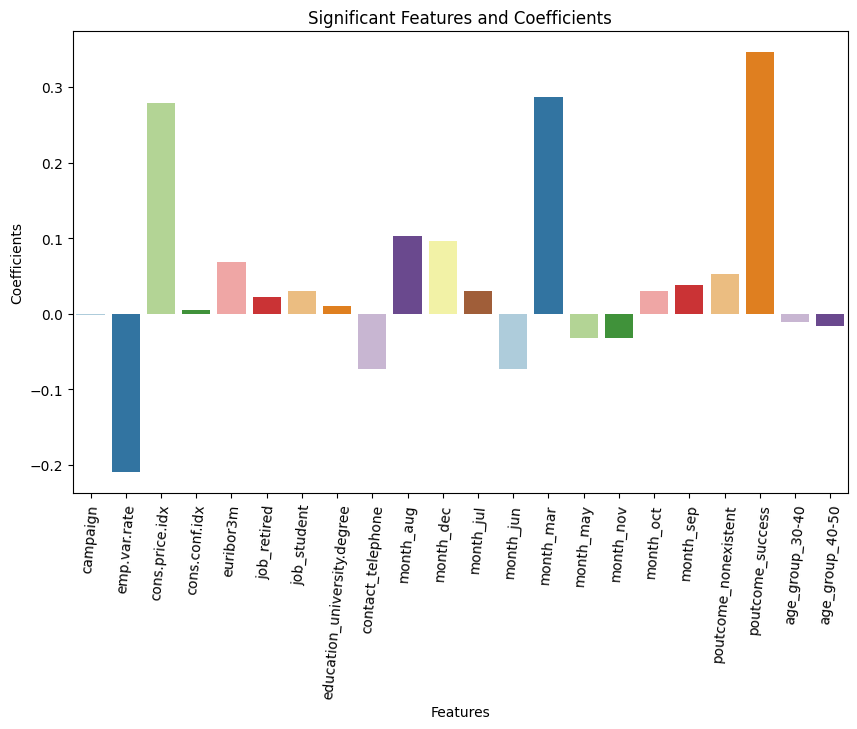

In [175]:
# Get signiifcant features and show their coefficients
significant_features = results.pvalues[results.pvalues < 0.05].index

# Remove 'const'  from significant_features
significant_features = significant_features.drop('const')
print(significant_features)
print(results.params[significant_features])
# Visualization of most important features
plt.figure(figsize=(10, 6))
sns.barplot(x=significant_features, y=results.params[significant_features], palette=palette)
plt.xticks(rotation=85)
plt.title('Significant Features and Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

# Correlation

In [231]:
# Get 'campaign', 'cons.price.idx', 'euribor3m' in dummy_df
sub_df = dummy_df[['campaign', 'cons.price.idx', 'euribor3m', 'y']]
sub_df

,campaign,cons.price.idx,euribor3m,y
0,1,93.994,4.857,0
1,1,93.994,4.857,0
2,1,93.994,4.857,0
3,1,93.994,4.857,0
4,1,93.994,4.857,0
...,...,...,...,...
41183,1,94.767,1.028,1
41184,1,94.767,1.028,0
41185,2,94.767,1.028,0
41186,1,94.767,1.028,1


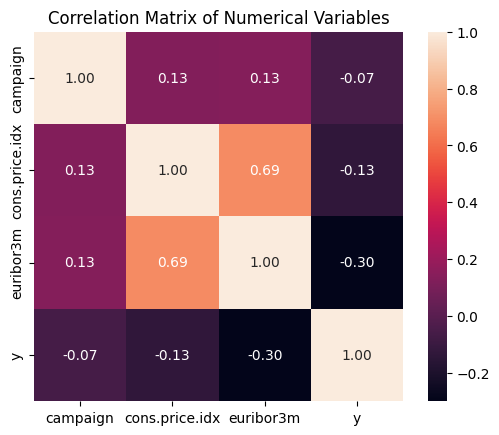

In [233]:
correlation_matrix = sub_df.corr()

# plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [176]:
encoded_df

,job,marital,education,housing,loan,contact,month,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,3,1,0,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2
1,7,1,1,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2
2,7,1,1,1,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,0
3,0,1,0,0,0,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,0
4,7,1,1,0,1,1,6,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5,1,3,1,0,0,7,1,1,-1.1,94.767,-50.8,1.028,4963.6,1,2
41184,1,1,3,0,0,0,7,1,1,-1.1,94.767,-50.8,1.028,4963.6,0,1
41185,5,1,4,1,0,0,7,2,1,-1.1,94.767,-50.8,1.028,4963.6,0,2
41186,9,1,3,0,0,0,7,1,1,-1.1,94.767,-50.8,1.028,4963.6,1,1


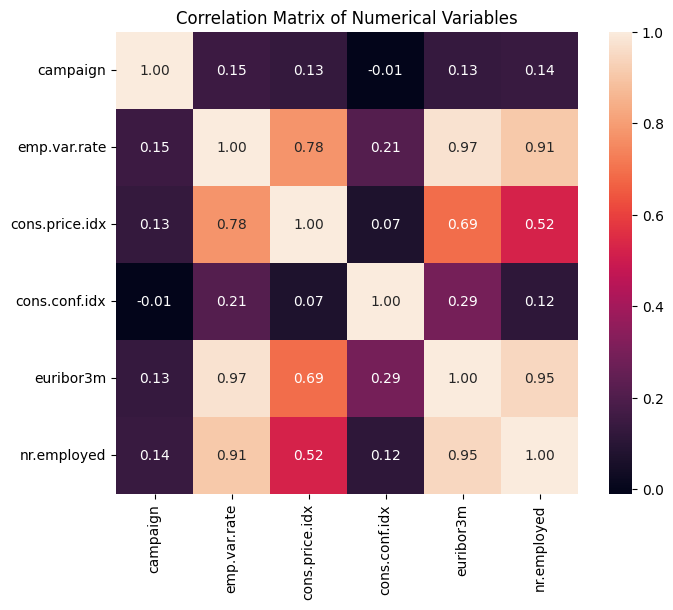

In [177]:
correlation_matrix = encoded_df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [178]:
correlation_results = []

for i in correlation_matrix.index:
    for j in correlation_matrix.columns:
        if i == j:
            continue
        r_value = pearsonr(encoded_df[i], encoded_df[j])[0]
        p_value = pearsonr(encoded_df[i], encoded_df[j])[1]
        
        correlation_results.append((i, j, r_value, p_value))
        
correlation_results_sorted = sorted(correlation_results, key=lambda x: x[2], reverse=True)

for result in correlation_results_sorted:
    i, j, r_value, p_value = result
    if p_value < 0.05:
        print(f"Correlation between '{i}' and '{j}': r = {r_value:.2f}, p = {p_value:.4f} (significant)")

Correlation between 'emp.var.rate' and 'euribor3m': r = 0.97, p = 0.0000 (significant)
Correlation between 'euribor3m' and 'emp.var.rate': r = 0.97, p = 0.0000 (significant)
Correlation between 'euribor3m' and 'nr.employed': r = 0.95, p = 0.0000 (significant)
Correlation between 'nr.employed' and 'euribor3m': r = 0.95, p = 0.0000 (significant)
Correlation between 'emp.var.rate' and 'nr.employed': r = 0.91, p = 0.0000 (significant)
Correlation between 'nr.employed' and 'emp.var.rate': r = 0.91, p = 0.0000 (significant)
Correlation between 'emp.var.rate' and 'cons.price.idx': r = 0.78, p = 0.0000 (significant)
Correlation between 'cons.price.idx' and 'emp.var.rate': r = 0.78, p = 0.0000 (significant)
Correlation between 'cons.price.idx' and 'euribor3m': r = 0.69, p = 0.0000 (significant)
Correlation between 'euribor3m' and 'cons.price.idx': r = 0.69, p = 0.0000 (significant)
Correlation between 'cons.price.idx' and 'nr.employed': r = 0.52, p = 0.0000 (significant)
Correlation between 'nr

In [179]:
# Remove the columns whose coefficient > 0.95
columns_to_remove = []
for result in correlation_results_sorted:
    i, j, r_value, p_value = result
    if r_value > 0.90:
        columns_to_remove.append(j)

df_filtered = encoded_df.drop(columns=columns_to_remove, errors='ignore')

print("Removed columns:")
print(columns_to_remove)
display(df_filtered)

Removed columns:
['euribor3m', 'emp.var.rate', 'nr.employed', 'euribor3m', 'nr.employed', 'emp.var.rate']


,job,marital,education,housing,loan,contact,month,campaign,poutcome,cons.price.idx,cons.conf.idx,y,age_group
0,3,1,0,0,0,1,6,1,1,93.994,-36.4,0,2
1,7,1,1,0,0,1,6,1,1,93.994,-36.4,0,2
2,7,1,1,1,0,1,6,1,1,93.994,-36.4,0,0
3,0,1,0,0,0,1,6,1,1,93.994,-36.4,0,0
4,7,1,1,0,1,1,6,1,1,93.994,-36.4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5,1,3,1,0,0,7,1,1,94.767,-50.8,1,2
41184,1,1,3,0,0,0,7,1,1,94.767,-50.8,0,1
41185,5,1,4,1,0,0,7,2,1,94.767,-50.8,0,2
41186,9,1,3,0,0,0,7,1,1,94.767,-50.8,1,1


In [180]:
# Define filetered num_cols and cat_cols
filtered_num_cols = ['poutcome', 'cons.price.idx', 'cons.conf.idx']
filtered_cat_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'campaign', 'age_group']
# Check if the sum of 2 columns equals to the length of df_filtered.columns() and 'y'
print(len(filtered_num_cols) + len(filtered_cat_cols) == len(df_filtered.columns)-1)

True


In [181]:
# Standarize the numerical columns
scaler = StandardScaler() # Initialize StandardScaler
df_filtered[filtered_num_cols] = scaler.fit_transform(df_filtered[filtered_num_cols])
df_filtered.head()

,job,marital,education,housing,loan,contact,month,campaign,poutcome,cons.price.idx,cons.conf.idx,y,age_group
0,3,1,0,0,0,1,6,1,0.194951,0.735109,0.895747,0,2
1,7,1,1,0,0,1,6,1,0.194951,0.735109,0.895747,0,2
2,7,1,1,1,0,1,6,1,0.194951,0.735109,0.895747,0,0
3,0,1,0,0,0,1,6,1,0.194951,0.735109,0.895747,0,0
4,7,1,1,0,1,1,6,1,0.194951,0.735109,0.895747,0,2


# Feature selection

In [182]:
X = df_filtered.drop(['y'],axis=1)
y = df_filtered['y']
# Feature selection
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(X.values, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X.values)

# Get the selected feature names
selected_features_index = model.get_support()
selected_features = X.columns[selected_features_index]
print("Selected features:")
for feature in selected_features:
    print(feature)

Selected features:
job
campaign
poutcome
cons.price.idx
cons.conf.idx


# Split the data and balance the data

In [209]:
# Split the data into training and testing sets (80% training, 20% test)
X_feature =  df_filtered[selected_features] # selected features only
X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, stratify=y,random_state=42)
# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (30596, 5) (30596,)
Testing set shape: (7649, 5) (7649,)


In [198]:
# # SMOTE (Synthetic Minority Oversampling Technique)
# sm = SMOTE(sampling_strategy='auto', random_state=42)
# X_train,y_train=sm.fit_resample(X_train,y_train)

In [210]:
X_train

,job,campaign,poutcome,cons.price.idx,cons.conf.idx
36978,9,2,-2.573675,-1.910811,1.501396
32831,9,2,-2.573675,-1.175158,-1.224024
23360,9,7,0.194951,-0.219157,0.960638
17494,1,1,0.194951,0.603247,-0.466963
31994,4,4,0.194951,-1.175158,-1.224024
...,...,...,...,...,...
36934,2,1,0.194951,-1.053706,-0.055987
1631,0,2,0.194951,0.735109,0.895747
35918,1,1,0.194951,-1.175158,-1.224024
13146,3,1,0.194951,0.603247,-0.466963


/Users/chenyuchieh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


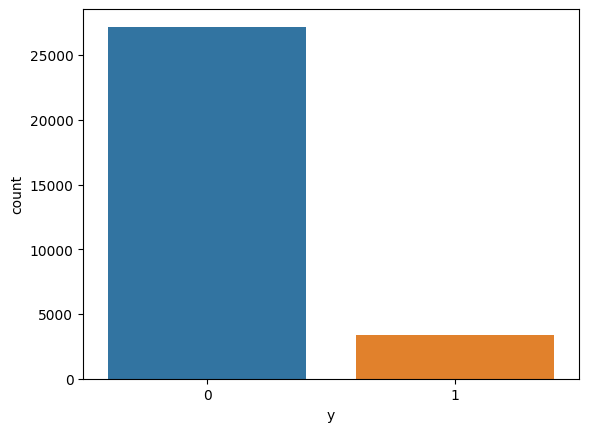

In [211]:
sns.countplot(y_train)
plt.show()

In [74]:
# X_train=scaler.fit_transform(X_train)
# X_test=scaler.transform(X_test)

# Machine Learning

## SVM Training & Testing

In [220]:
y_train

36978    1
32831    0
23360    1
17494    0
31994    0
        ..
36934    1
1631     0
35918    0
13146    0
29069    0
Name: y, Length: 30596, dtype: int64

In [212]:
# Tuning the SVM
pipe = Pipeline(steps=[("SVC", LinearSVC())])# Parameters of pipelines can be set using ‘__’ separated parameter names:

param_grid = {
'SVC__dual': [False], 'SVC__intercept_scaling': np.logspace(-10, 10, 10), 'SVC__penalty':['l2'], 'SVC__fit_intercept': [True, False], 'SVC__loss': ['hinge', 'squared_hinge'], 'SVC__C':np.logspace(-10, 10, 10), 'SVC__class_weight': ['balanced', None] 
}
clf = GridSearchCV(pipe, param_grid, n_jobs=5, cv=5, verbose=3)

clf.fit(X_train, y_train)

print(f"Best score : {clf.best_score_}")
print(clf.best_params_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best score : 0.8897894696365227
{'SVC__C': 12.915496650148826, 'SVC__class_weight': None, 'SVC__dual': False, 'SVC__fit_intercept': True, 'SVC__intercept_scaling': 1e-10, 'SVC__loss': 'squared_hinge', 'SVC__penalty': 'l2'}


/Users/chenyuchieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2000 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chenyuchieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chenyuchieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/chenyuchieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line

In [ ]:
# # Tuning the SVM
# pipe = Pipeline(steps=[("SVC", SVC())]) # Change LinearSVC to SVC for using different kernels
# param_grid = {
#     'SVC__C': np.logspace(-10, 10, 10),
#     'SVC__kernel': ['linear', 'poly', 'rbf'],  # Try different kernels
#     'SVC__gamma': ['scale', 'auto'],  # Gamma for 'rbf' and 'poly' kernels
#     'SVC__class_weight': ['balanced', None]
# }
# clf = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, verbose=3) # Increase cv to 10 for better cross-validation

# clf.fit(X_train, y_train)

# print(f"Best score : {clf.best_score_}")
# print(clf.best_params_)

Testing accuracy: 0.8913583474964047
Confusion matrix:
 [[6747   50]
 [ 781   71]]


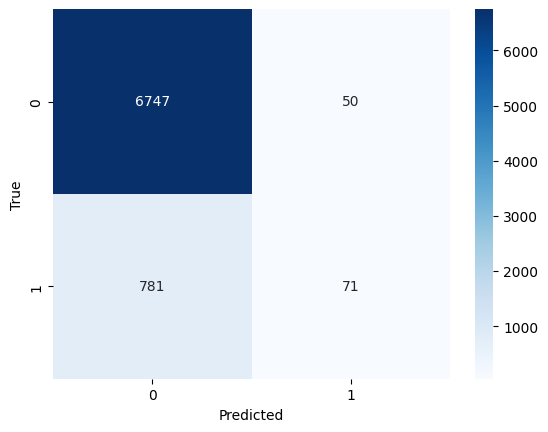

Precision: 0.5867768595041323
Recall: 0.08333333333333333
F1 score: 0.1459403905447071


In [213]:
# Predict on the test set using the best model
y_pred = clf.best_estimator_.predict(X_test)
print("Testing accuracy:", accuracy_score(y_test, y_pred))  # Print the accuracy of the best model on the testing set
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
# Visualization with heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

In [217]:
importances

array([-0.04973813, -0.2308762 ,  0.12158083, -0.09801153,  0.02507471])

In [216]:
X

,job,marital,education,housing,loan,contact,month,campaign,poutcome,cons.price.idx,cons.conf.idx,age_group
0,3,1,0,0,0,1,6,1,0.194951,0.735109,0.895747,2
1,7,1,1,0,0,1,6,1,0.194951,0.735109,0.895747,2
2,7,1,1,1,0,1,6,1,0.194951,0.735109,0.895747,0
3,0,1,0,0,0,1,6,1,0.194951,0.735109,0.895747,0
4,7,1,1,0,1,1,6,1,0.194951,0.735109,0.895747,2
...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5,1,3,1,0,0,7,1,0.194951,2.076287,-2.219019,2
41184,1,1,3,0,0,0,7,1,0.194951,2.076287,-2.219019,1
41185,5,1,4,1,0,0,7,2,0.194951,2.076287,-2.219019,2
41186,9,1,3,0,0,0,7,1,0.194951,2.076287,-2.219019,1


In [215]:
# Visualize the importance of each feature
importances = clf.best_estimator_.named_steps['SVC'].coef_[0]
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

ValueError: All arrays must be of the same length

## Logistic Regression

In [208]:
# Tuning the LR
pipe = Pipeline(steps=[("LR", LogisticRegression())]) # Parameters of pipelines can be set using ‘__’ separated parameter names:

param_grid = {
    'LR__fit_intercept': [True, False], 'LR__C': np.logspace(-5, 5, 20), 'LR__class_weight': [None, 'balanced']}

clf = GridSearchCV(pipe, param_grid, n_jobs=5, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='balanced_accuracy', verbose=1)

clf.fit(X_train, y_train)

print(f"Best score : {clf.best_score_}")
print(clf.best_params_)

NameError: name 'StratifiedKFold' is not defined

In [ ]:
# Predict on the test set using the best model
y_pred = clf.best_estimator_.predict(X_test)
print("Testing accuracy:", accuracy_score(y_test, y_pred))  # Print the accuracy of the best model on the testing set
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
# Visualization with heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

In [ ]:
# Visualize the importance of each feature
importances = clf.best_estimator_.named_steps['LR'].coef_[0]
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Multiple Linear Regression

In [ ]:
# Assuming X_train and y_train are your training features and target respectively
X_train = sm.add_constant(X_train)  # Add a constant term to the features
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

# Assuming X_test is your test features
X_test = sm.add_constant(X_test)  # Add a constant term to the test features
predictions = results.predict(X_test)

# Evaluate the model with RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)